#Project 3

## Install Dependencies

In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 5.9 MB/s eta 0:00:00


## Drive Config, Import Library, Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path

PROJECT_ROOT = Path('/content/drive/MyDrive/Proyek/Data/project3')
DATA_DIR = PROJECT_ROOT / "data"
TRAIN_PATH = DATA_DIR / "train.csv"

print(f"Dataset path set to: {TRAIN_PATH}")
if not TRAIN_PATH.exists():
    print("Warning: file belum ditemukan. Letakkan 'train.csv' di folder data/ .")

Dataset path set to: /content/drive/MyDrive/Proyek/Data/project3/data/train.csv


In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor, Pool
from lightgbm import LGBMRegressor

from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
import statsmodels.api as sm

import optuna


In [ ]:
if not TRAIN_PATH.exists():
    raise FileNotFoundError(f"Dataset tidak ditemukan di {TRAIN_PATH}")

df = pd.read_csv(TRAIN_PATH)
target = "SalePrice"
if 'Id' in df.columns:
    df.drop(columns=['Id'], inplace=True)
    print("Kolom 'Id' telah di-drop.")
print(df.columns)

Kolom 'Id' telah di-drop.
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond'

In [ ]:
len(df)

1460

## 🏡 Ames Housing Dataset — Short Column Description

## 🔢 Identitas
- **Id** — ID unik untuk setiap rumah.

---

## 🏠 Lot & Zoning
- **MSSubClass** — Kategori tipe bangunan.
- **MSZoning** — Klasifikasi zona perumahan.
- **LotFrontage** — Panjang sisi tanah yang menghadap jalan.
- **LotArea** — Luas tanah (sq ft).
- **Street** — Jenis akses jalan.
- **Alley** — Akses gang.
- **LotShape** — Bentuk tanah.
- **LandContour** — Kontur permukaan tanah.
- **Utilities** — Ketersediaan utilitas.
- **LotConfig** — Konfigurasi posisi rumah di lahan.
- **LandSlope** — Kemiringan tanah.
- **Neighborhood** — Lokasi lingkungan di kota Ames.
- **Condition1** — Kedekatan dengan jalan besar/rel kereta.
- **Condition2** — Kedekatan sekunder dengan jalan/rel.

---

## 🏘️ Tipe Bangunan & Gaya Rumah
- **BldgType** — Jenis hunian (single family, duplex, dll).
- **HouseStyle** — Gaya rumah (1 lantai, 2 lantai, split, dll).

---

## 🧱 Kualitas & Kondisi
- **OverallQual** — Kualitas material & pengerjaan keseluruhan.
- **OverallCond** — Kondisi keseluruhan bangunan.
- **YearBuilt** — Tahun pembangunan rumah.
- **YearRemodAdd** — Tahun renovasi terakhir.

---

## 🏚️ Exterior & Atap
- **RoofStyle** — Jenis atap.
- **RoofMatl** — Material atap.
- **Exterior1st** — Material exterior pertama.
- **Exterior2nd** — Material exterior kedua.
- **MasVnrType** — Jenis batu bata veneer.
- **MasVnrArea** — Luas veneer.
- **ExterQual** — Kualitas exterior.
- **ExterCond** — Kondisi exterior.

---

## 🏠 Fondasi & Basement
- **Foundation** — Jenis fondasi.
- **BsmtQual** — Kualitas basement.
- **BsmtCond** — Kondisi basement.
- **BsmtExposure** — Basement walkout/garden level.
- **BsmtFinType1** — Tipe ruangan basement selesai 1.
- **BsmtFinSF1** — Luas tipe selesai 1.
- **BsmtFinType2** — Tipe ruangan selesai 2.
- **BsmtFinSF2** — Luas tipe selesai 2.
- **BsmtUnfSF** — Luas basement tidak selesai.
- **TotalBsmtSF** — Total luas basement.

---

## 🔥 Sistem Pemanas & Listrik
- **Heating** — Sistem pemanas.
- **HeatingQC** — Kualitas pemanas.
- **CentralAir** — AC sentral (Y/N).
- **Electrical** — Sistem kelistrikan.

---

## 📐 Luas Area Tinggal
- **1stFlrSF** — Luas lantai 1.
- **2ndFlrSF** — Luas lantai 2.
- **LowQualFinSF** — Area kualitas rendah yang selesai.
- **GrLivArea** — Total area tinggal di atas tanah.

---

## 🚿 Kamar Mandi
- **BsmtFullBath** — Jumlah kamar mandi penuh di basement.
- **BsmtHalfBath** — Kamar mandi setengah di basement.
- **FullBath** — Kamar mandi penuh di atas tanah.
- **HalfBath** — Kamar mandi setengah di atas tanah.

---

## 🛏️ Kamar & Dapur
- **BedroomAbvGr** — Jumlah kamar tidur di atas tanah.
- **KitchenAbvGr** — Jumlah dapur.
- **KitchenQual** — Kualitas dapur.
- **TotRmsAbvGrd** — Total jumlah ruangan di atas tanah.

---

## 🚪 Fungsi Rumah & Perapian
- **Functional** — Penilaian fungsi keseluruhan rumah.
- **Fireplaces** — Jumlah perapian.
- **FireplaceQu** — Kualitas perapian.

---

## 🚗 Garasi
- **GarageType** — Lokasi garasi.
- **GarageYrBlt** — Tahun garasi dibangun.
- **GarageFinish** — Finishing interior garasi.
- **GarageCars** — Kapasitas garasi (jumlah mobil).
- **GarageArea** — Luas garasi.
- **GarageQual** — Kualitas garasi.
- **GarageCond** — Kondisi garasi.

---

## 🏡 Fitur Exterior Tambahan
- **PavedDrive** — Jenis jalan masuk (paved).
- **WoodDeckSF** — Luas dek kayu.
- **OpenPorchSF** — Luas serambi terbuka.
- **EnclosedPorch** — Luas serambi tertutup.
- **3SsnPorch** — Serambi 3 musim.
- **ScreenPorch** — Serambi dengan layar/jaring.
- **PoolArea** — Luas kolam.
- **PoolQC** — Kualitas kolam.
- **Fence** — Kualitas pagar.
- **MiscFeature** — Fitur tambahan lainnya.
- **MiscVal** — Nilai dari fitur tambahan.

---

## 📅 Informasi Penjualan
- **MoSold** — Bulan penjualan.
- **YrSold** — Tahun penjualan.
- **SaleType** — Tipe penjualan.
- **SaleCondition** — Kondisi penjualan.
- **SalePrice** — Harga jual (target).

## EDA

### Distribusi Harga & Ukuran Rumah

Umumnya rumah dengan living area lebih besar lebih mahal → validasi asumsi dasar untuk developer/agen.

Outlier bisa terdeteksi: rumah besar tapi murah, mungkin butuh inspeksi atau renovasi.

In [ ]:
# Distribusi SalePrice
fig = px.histogram(
    df,
    x='SalePrice',
    nbins=50,
    color_discrete_sequence=['#1f77b4'],
    marginal='box'
)

fig.update_layout(
    title='Distribusi Harga Rumah',
    xaxis_title='SalePrice',
    yaxis_title='Count',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    bargap=0.1
)

fig.update_traces(marker_line_color='white', marker_line_width=1)
fig.show()

In [ ]:
# 2. Scatter GrLivArea vs SalePrice
fig = px.scatter(
    df,
    x='GrLivArea',
    y='SalePrice',
    color_discrete_sequence=['#1f77b4'],
    opacity=0.7
)

fig.update_layout(
    title='Harga vs Living Area',
    xaxis_title='GrLivArea',
    yaxis_title='SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black')
)

fig.update_traces(marker=dict(size=6, line=dict(width=1, color='white')))
fig.show()

### Kualitas Rumah vs Harga

Harga naik tajam seiring OverallQual.

Bisa dijadikan panduan untuk strategi upgrade rumah: menambahkan kualitas tertentu bisa signifikan menaikkan harga jual.

In [ ]:
# Group by dan median
df_grouped = df.groupby('OverallQual')['SalePrice'].median().reset_index()
df_grouped['OverallQual'] = df_grouped['OverallQual'].astype(str)

# Warna soft → dark untuk 10 kategori
blue_colors = ['#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b','#041f3b','#010f1f']
overall_order = [str(i) for i in range(1,11)]

fig = px.bar(
    df_grouped,
    x='OverallQual',
    y='SalePrice',
    color='OverallQual',
    category_orders={'OverallQual': overall_order},
    color_discrete_sequence=blue_colors
)

fig.update_layout(
    title='Overall Quality vs Median SalePrice',
    xaxis_title='OverallQual',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

### Kombinasi Kualitas Interior & Eksterior

kualitas mana yang paling meningkatkan nilai jual dan kombinasi mana yang memberi efek terbesar.

In [ ]:
exter_order = ['Po','Fa','TA','Gd','Ex']
kitchen_order = ['Po','Fa','TA','Gd','Ex']

soft_colors = {
    'Ex':'#6baed6',   # soft blue
    'Gd':'#9ecae1',   # lighter blue
    'TA':'#c6dbef',   # very light blue
    'Fa':'#fdd0a2',   # soft orange
    'Po':'#fdae6b'    # medium soft orange
}

fig = px.bar(
    df.groupby(['ExterQual','KitchenQual'])['SalePrice'].median().reset_index(),
    x='ExterQual',
    y='SalePrice',
    color='KitchenQual',
    category_orders={'ExterQual': exter_order, 'KitchenQual': kitchen_order},
    color_discrete_map=soft_colors,
    barmode='group'
)

fig.update_layout(
    title='ExterQual vs KitchenQual (Median SalePrice)',
    xaxis_title='ExterQual',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black')
)

fig.show()

### Lokasi

In [ ]:
df_grouped = df.groupby('Neighborhood')['SalePrice'].median().reset_index()

fig = px.bar(
    df_grouped,
    x='Neighborhood',
    y='SalePrice',
    color='SalePrice',
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='Median SalePrice per Neighborhood',
    xaxis_title='Neighborhood',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
)

fig.update_xaxes(tickangle=45)
fig.show()

### Tipe Penjualan & Kondisi Rumah

Kondisi Partial atau Abnorml kadang memberi harga lebih tinggi/lebih rendah.


In [ ]:
df_grouped = df.groupby('SaleCondition')['SalePrice'].median().reset_index()

fig = px.bar(
    df_grouped,
    x='SaleCondition',
    y='SalePrice',
    color='SalePrice',
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='SaleCondition vs Median SalePrice',
    xaxis_title='SaleCondition',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

In [ ]:
df.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Tipe penjualan tertentu (New, COD, ConLw) dapat memberi info pola harga → strategi pricing untuk tipe serupa di masa depan.

In [ ]:
df_grouped = df.groupby('SaleType')['SalePrice'].median().reset_index()

fig = px.bar(
    df_grouped,
    x='SaleType',
    y='SalePrice',
    color='SalePrice',
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='SaleType vs Median SalePrice',
    xaxis_title='SaleType',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

### Basement & Lot Configuration

Basement exposure baik (Av, Gd) → tambah nilai rumah.

Lot corner atau cul-de-sac biasanya lebih mahal → insight investasi properti premium.

In [ ]:
df_grouped = df.groupby('BsmtExposure')['SalePrice'].median().reset_index()

soft_colors = ['#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5']

fig = px.bar(
    df_grouped,
    x='BsmtExposure',
    y='SalePrice',
    color='SalePrice',
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='Basement Exposure vs Median SalePrice',
    xaxis_title='BsmtExposure',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

In [ ]:
df_grouped = df.groupby('LotConfig')['SalePrice'].median().reset_index()

fig = px.bar(
    df_grouped,
    x='LotConfig',
    y='SalePrice',
    color='SalePrice',
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='LotConfig vs Median SalePrice',
    xaxis_title='LotConfig',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

### Fireplace

Kualitas fireplace jarang dilihat, tapi bisa menambah nilai rumah, khususnya untuk pasar premium.

Developer bisa menambah fitur ini untuk rumah high-end.

In [ ]:
df_grouped = df.groupby('FireplaceQu')['SalePrice'].median().reset_index()

fig = px.bar(
    df_grouped,
    x='FireplaceQu',
    y='SalePrice',
    color='SalePrice',
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='Fireplace Quality vs Median SalePrice',
    xaxis_title='Fireplace Quality',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

### Harga per Square Foot

Rumah tua tapi harga per sqft tinggi → rumah bersejarah / lokasi premium.

In [ ]:
fig = px.scatter(
    df,
    x='YearBuilt',
    y=df['SalePrice'] / df['GrLivArea'],
    color=df['SalePrice'] / df['GrLivArea'],
    color_continuous_scale='Blues',
    hover_data=['SalePrice', 'GrLivArea']
)

fig.update_layout(
    title='Price per Sqft vs Year Built',
    xaxis_title='Year Built',
    yaxis_title='Price per Sqft',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    coloraxis_colorbar=dict(title='Price per Sqft')
)

fig.show()

### Garasi

Tipe dan umur garasi memengaruhi harga, terutama rumah keluarga / pinggiran kota.



In [ ]:
df_grouped = df.groupby('GarageType')['SalePrice'].median().reset_index()

fig = px.bar(
    df_grouped,
    x='GarageType',
    y='SalePrice',
    color='SalePrice',
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='Garage Type vs Median SalePrice',
    xaxis_title='Garage Type',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

### Analisis Miscellaneous

Functional (layout rumah) → peluang renovasi untuk layout kurang optimal.

Zoning (MSZoning) memberi gambaran regulasi & potensi pembangunan → insight untuk investasi jangka panjang.

In [ ]:
df_grouped = df.groupby('Functional')['SalePrice'].median().reset_index()

fig = px.bar(
    df_grouped,
    x='Functional',
    y='SalePrice',
    color='SalePrice',  # continuous color sesuai median
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='Functional vs Median SalePrice',
    xaxis_title='Functional',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

In [ ]:
df_grouped = df.groupby('MSZoning')['SalePrice'].median().reset_index()

fig = px.bar(
    df_grouped,
    x='MSZoning',
    y='SalePrice',
    color='SalePrice',
    color_continuous_scale='Blues'
)

fig.update_layout(
    title='MSZoning vs Median SalePrice',
    xaxis_title='MSZoning',
    yaxis_title='Median SalePrice',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family='Arial', size=12, color='black'),
    showlegend=False
)

fig.show()

## Feature Engineering

| Kategori               | Nama Kolom                            | Deskripsi                                                             |
| ---------------------- | ------------------------------------- | --------------------------------------------------------------------- |
| Umur & Renovasi        | `AgeAtSale`                           | Usia bangunan saat dijual (`YrSold – YearBuilt`)                      |
|                        | `TimeSinceRemod`                      | Waktu sejak renovasi terakhir sampai dijual (`YrSold – YearRemodAdd`) |
|                        | `GarageAge`                           | Usia garasi saat dijual (`YrSold – GarageYrBlt`)                      |
| Area & Layout          | `TotalBath`                           | Jumlah total kamar mandi (full + ½ half + basement)                   |
|                        | `TotalPorch`                          | Total luas semua jenis teras / porch                                  |
|                        | `TotalLivArea`                        | Luas total area hidup: lantai atas + basement                         |
|                        | `RoomDensity`                         | Kepadatan ruangan = `TotRmsAbvGrd / GrLivArea`                        |
| Fitur Tambahan / Rasio | `HasPool`                             | 1 jika ada kolam renang, 0 jika tidak                                 |
|                        | `HasFence`                            | 1 jika ada pagar, 0 jika tidak                                        |
|                        | `LotToHouseRatio`                     | Rasio `LotArea` terhadap `GrLivArea`                                  |
|                        | `BathroomPerBedroom`                  | Rasio jumlah kamar mandi terhadap kamar tidur                         |
| Seasonality            | `IsWinterSale`                        | 1 jika penjualan di bulan Des / Jan / Feb, 0 jika tidak               |
| Encoding Kualitas      | `<col>_num` (contoh: `ExterQual_num`) | Nilai kualitas (Ex, Gd, TA, Fa, Po) diubah jadi angka 5–1             |


In [ ]:
# --- 1. Kolom dasar / EDA feature engineering ---
# Umur & renovasi
df['AgeAtSale'] = df['YrSold'] - df['YearBuilt']
df['TimeSinceRemod'] = df['YrSold'] - df['YearRemodAdd']
df['GarageAge'] = df['YrSold'] - df['GarageYrBlt']

# Area & layout
df['TotalBath'] = df['FullBath'] + 0.5*df['HalfBath'] + df['BsmtFullBath'] + 0.5*df['BsmtHalfBath']
df['TotalPorch'] = df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch'] + df['WoodDeckSF']
df['TotalLivArea'] = df['GrLivArea'] + df['TotalBsmtSF']
df['RoomDensity'] = df['TotRmsAbvGrd'] / df['GrLivArea'].replace(0, np.nan)

# Fitur tambahan / rasio
df['HasPool'] = (df['PoolArea'] > 0).astype(int)
df['HasFence'] = df['Fence'].notna().astype(int)
df['LotToHouseRatio'] = df['LotArea'] / df['GrLivArea'].replace(0, np.nan)
df['BathroomPerBedroom'] = df['TotalBath'] / df['BedroomAbvGr'].replace(0, np.nan)

# Seasonality
df['IsWinterSale'] = df['MoSold'].isin([12,1,2]).astype(int)

# --- 2. Encoding kualitas ---
qual_map = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}
qual_cols = ['ExterQual','ExterCond','KitchenQual','BsmtQual','BsmtCond','HeatingQC','GarageQual','GarageCond','FireplaceQu']

for col in qual_cols:
    df[col+'_num'] = df[col].map(qual_map)


### Umur Properti dan Renovasi

Rumah yang terlalu tua cenderung harga lebih rendah; strategi renovasi bisa menaikkan harga jual.

In [ ]:
fig = px.scatter(df, x='AgeAtSale', y='SalePrice', trendline='ols',
                 labels={'AgeAtSale':'Umur Rumah (tahun)','SalePrice':'Harga Jual'},
                 title='Harga Jual vs Umur Rumah',
                 color_discrete_sequence=['#2E86AB'])

fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()

Lama sejak renovasi (TimeSinceRemod)

In [ ]:
fig = px.scatter(df, x='TimeSinceRemod', y='SalePrice', trendline='ols',
                 labels={'TimeSinceRemod':'Tahun sejak Renovasi','SalePrice':'Harga Jual'},
                 title='Harga Jual vs Lama sejak Renovasi',
                 color_discrete_sequence=['#F28E2B'])

fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()

Garasi baru meningkatkan kesan kualitas properti dan dapat menaikkan harga jual.

In [ ]:
fig = px.scatter(df, x='GarageAge', y='SalePrice', trendline='ols',
                 labels={'GarageAge':'Usia Garasi','SalePrice':'Harga Jual'},
                 title='Harga Jual vs Usia Garasi',
                 color_discrete_sequence=['#76B041'])

fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()

### Area & Layout

Terlalu padat (banyak ruangan tapi kecil) cenderung harga lebih rendah per m² → strategi desain interior penting.

In [ ]:
fig = px.scatter(df, x='RoomDensity', y='SalePrice', trendline='ols',
                 labels={'RoomDensity':'Jumlah Ruangan per m²','SalePrice':'Harga Jual'},
                 title='Harga Jual vs Kepadatan Ruangan',
                 color_discrete_sequence=['#DD5182'])

fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()

### Fasilitas Tambahan : Pool / Fence

Fasilitas tambahan sederhana seperti kolam/pagar bisa menaikkan nilai jual rumah, tapi efeknya tidak sebesar luas atau kualitas material.

In [ ]:
fig = px.box(df, x=df['HasPool'].map({0:'Tidak', 1:'Ya'}), y='SalePrice',
             labels={'HasPool':'Memiliki Kolam','SalePrice':'Harga Jual'},
             title='Harga Jual vs Adanya Kolam',
             color_discrete_sequence=['#FFA600'], category_orders={'x': ['Ya', 'Tidak']} )
fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()

In [ ]:
fig = px.box(
    df,
    x=df['HasFence'].map({0:'Tidak', 1:'Ya'}),  # mapping langsung di sini
    y='SalePrice',
    labels={'x':'Memiliki Pagar', 'y':'Harga Jual'},
    title='Harga Jual vs Adanya Pagar',
    color_discrete_sequence=['#FF6361'],
    category_orders={'x': ['Ya', 'Tidak']}
)

fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()

###Rasio lahan vs bangunan (LotToHouseRatio)

Lahan yang sangat luas dibanding bangunannya tidak selalu membuat harga rumah lebih tinggi, tapi memberi ruang untuk perluasan atau pembangunan tambahan

In [ ]:
fig = px.scatter(df, x='LotToHouseRatio', y='SalePrice', trendline='ols',
                 labels={'LotToHouseRatio':'Rasio Lahan vs Bangunan','SalePrice':'Harga Jual'},
                 title='Harga Jual vs Rasio Lahan terhadap Bangunan',
                 color_discrete_sequence=['#58508D'])
fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()

### Bathroom per Bedroom (BathroomPerBedroom)

Keseimbangan kamar mandi dan kamar tidur penting untuk kenyamanan → bisa jadi strategi renovasi kecil tapi efektif.

In [ ]:
fig = px.scatter(df, x='BathroomPerBedroom', y='SalePrice', trendline='ols',
                 labels={'BathroomPerBedroom':'Jumlah Kamar Mandi per Kamar Tidur','SalePrice':'Harga Jual'},
                 title='Harga Jual vs Rasio Kamar Mandi per Kamar Tidur',
                 color_discrete_sequence=['#003f5c'])
fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()


### Seasonality

In [ ]:
fig = px.box(
    df,
    x=df['IsWinterSale'].map({0:'Tidak', 1:'Ya'}),  # mapping langsung
    y='SalePrice',
    labels={'x':'Dijual Musim Dingin', 'y':'Harga Jual'},
    title='Harga Jual vs Musim Penjualan',
    color_discrete_sequence=['#bc5090'],
    category_orders={'x': ['Ya', 'Tidak']}
)

fig.update_layout(template='simple_white', title={'x':0.5})
fig.show()

## Preprocessing

### Missing Value

In [ ]:
import pandas as pd

def missing_value_analysis(df, threshold_drop=0.3):
    """
    Analisis missing value dan beri saran:
    - Drop jika missing > threshold_drop
    - Impute jika missing <= threshold_drop

    threshold_drop: persentase maksimal missing value untuk tetap diimpute
    """
    results = []
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_pct = df[col].isnull().mean()
        dtype = df[col].dtype

        if missing_count == 0:
            action = "Tidak ada missing value"
        elif missing_pct > threshold_drop:
            action = "Drop kolom"
        else:
            if pd.api.types.is_numeric_dtype(dtype):
                action = "Impute dengan mean/median"
            else:
                action = "Impute dengan modus"

        results.append({
            "Kolom": col,
            "Tipe": dtype,
            "Missing_Count": missing_count,
            "Missing_Pct": round(missing_pct*100, 2),
            "Saran": action
        })

    return pd.DataFrame(results)

# Contoh penggunaan
df_analysis = missing_value_analysis(df)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

df_analysis


,Kolom,Tipe,Missing_Count,Missing_Pct,Saran
0,MSSubClass,int64,0,0.00,Tidak ada missing value
1,MSZoning,object,0,0.00,Tidak ada missing value
2,LotFrontage,float64,259,17.74,Impute dengan mean/median
3,LotArea,int64,0,0.00,Tidak ada missing value
4,Street,object,0,0.00,Tidak ada missing value
5,Alley,object,1369,93.77,Drop kolom
6,LotShape,object,0,0.00,Tidak ada missing value
7,LandContour,object,0,0.00,Tidak ada missing value
8,Utilities,object,0,0.00,Tidak ada missing value
9,LotConfig,object,0,0.00,Tidak ada missing value


In [ ]:
no_missing = df_analysis[df_analysis['Saran'] != "Tidak ada missing value"]
no_missing

,Kolom,Tipe,Missing_Count,Missing_Pct,Saran
2,LotFrontage,float64,259,17.74,Impute dengan mean/median
5,Alley,object,1369,93.77,Drop kolom
24,MasVnrType,object,872,59.73,Drop kolom
25,MasVnrArea,float64,8,0.55,Impute dengan mean/median
29,BsmtQual,object,37,2.53,Impute dengan modus
30,BsmtCond,object,37,2.53,Impute dengan modus
31,BsmtExposure,object,38,2.60,Impute dengan modus
32,BsmtFinType1,object,37,2.53,Impute dengan modus
34,BsmtFinType2,object,38,2.60,Impute dengan modus
41,Electrical,object,1,0.07,Impute dengan modus


### Handling Missing Value

In [ ]:
def preprocess_missing(df, threshold_drop=0.3):
    """
    Preprocessing missing value otomatis:
    - Drop kolom > threshold_drop
    - Impute numerik ≤ threshold_drop dengan median
    - Impute kategorikal ≤ threshold_drop dengan modus
    """
    df = df.copy()

    # =========================
    # Drop kolom > threshold
    # =========================
    missing_pct = df.isnull().mean()
    drop_cols = missing_pct[missing_pct > threshold_drop].index.tolist()
    df.drop(columns=drop_cols, inplace=True)
    print(f"Kolom di-drop (> {threshold_drop*100}% missing): {drop_cols}")

    # =========================
    # Ganti infinity dengan NaN
    # =========================
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # =========================
    # Impute kolom numerik
    # =========================
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    if len(num_cols) > 0:
        num_imputer = SimpleImputer(strategy='median')
        df[num_cols] = num_imputer.fit_transform(df[num_cols])
        print(f"Kolom numerik di-impute dengan median: {num_cols.tolist()}")

    # =========================
    # Impute kolom kategorikal
    # =========================
    cat_cols = df.select_dtypes(include=['object']).columns
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy='most_frequent')
        df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])
        print(f"Kolom kategorikal di-impute dengan modus: {cat_cols.tolist()}")

    return df

# =========================
# Contoh penggunaan
# =========================
df_temp=df.copy()
df_clean = preprocess_missing(df)
df=df_clean


Kolom di-drop (> 30.0% missing): ['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'FireplaceQu_num']
Kolom numerik di-impute dengan median: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'AgeAtSale', 'TimeSinceRemod', 'GarageAge', 'TotalBath', 'TotalPorch', 'TotalLivArea', 'RoomDensity', 'HasPool', 'HasFence', 'LotToHouseRatio', 'BathroomPerBedroom', 'IsWinterSale', 'ExterQual_num', 'ExterCond_num', 'KitchenQual_num', 'BsmtQual_num', 'BsmtCond_num', 'HeatingQC_num', 'GarageQual_num', 'GarageCond_num']
Ko

In [ ]:
df_analysis = missing_value_analysis(df)
df_analysis

,Kolom,Tipe,Missing_Count,Missing_Pct,Saran
0,MSSubClass,float64,0,0.0,Tidak ada missing value
1,MSZoning,object,0,0.0,Tidak ada missing value
2,LotFrontage,float64,0,0.0,Tidak ada missing value
3,LotArea,float64,0,0.0,Tidak ada missing value
4,Street,object,0,0.0,Tidak ada missing value
5,LotShape,object,0,0.0,Tidak ada missing value
6,LandContour,object,0,0.0,Tidak ada missing value
7,Utilities,object,0,0.0,Tidak ada missing value
8,LotConfig,object,0,0.0,Tidak ada missing value
9,LandSlope,object,0,0.0,Tidak ada missing value


In [ ]:
# identify categorical vs numeric
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(exclude=["object"]).columns.tolist()

print("Categorical columns:")
print(cat_cols)

print("\nNumeric columns:")
print(num_cols)


Categorical columns:
['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

Numeric columns:
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPor

In [ ]:
forced_categorical = [
    "MSSubClass", "OverallQual", "OverallCond",
    "BsmtFullBath", "BsmtHalfBath", "FullBath", "HalfBath",
    "BedroomAbvGr", "KitchenAbvGr", "Fireplaces",
    "GarageCars", "MoSold", "YrSold", "TotRmsAbvGrd",
    "Functional", "PavedDrive"
]

# ubah ke kategori
for col in forced_categorical:
    if col in df.columns:
        df[col] = df[col].astype("category")

# deteksi ulang
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = df.select_dtypes(exclude=["object", "category"]).columns.tolist()

print("Categorical columns:", cat_cols)
print("Numeric columns:", num_cols)


Categorical columns: ['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Numeric columns: ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3Ss

In [ ]:
# =========================
# Dataset untuk modelling
# =========================
leakage_cols = [
    'PricePerSqft', 'SalePrice_RollingMedian_3Mo', 'Neighborhood_CumAvgPrice',
    'PrevMonthPrice', 'PriceChangeMo', 'Neigh_MeanPrice', 'Neigh_MedianPrice',
    'Neigh_StdPrice', 'HouseStyle_MedianPrice', 'Price_vs_Neigh'
]

model_df = df.drop(columns=[col for col in leakage_cols if col in df.columns]).copy()




### Handling Outlier

In [ ]:
# Outlier handling sederhana
high_area_low_price = (model_df['GrLivArea'] > 4000) & (model_df[target] < 400000)
high_price = model_df[target] > 700000
model_df = model_df.loc[~(high_area_low_price | high_price)].reset_index(drop=True)
print(f"Dataset setelah filter outlier: {model_df.shape}")

Dataset setelah filter outlier: (1456, 94)


### Feature Selection

In [ ]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
from sklearn.feature_selection import RFE
import numpy as np
# --- Data & target ---
target_col = 'SalePrice'

X = model_df.drop(columns=[target_col])
y = model_df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Numeric Features ---
model_numeric_features = [
    'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
    'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
    'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
    'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
    'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
    'AgeAtSale', 'TimeSinceRemod', 'GarageAge', 'TotalBath', 'TotalPorch',
    'TotalLivArea', 'RoomDensity', 'LotToHouseRatio', 'BathroomPerBedroom',
    'ExterQual_num', 'ExterCond_num', 'KitchenQual_num', 'BsmtQual_num',
    'BsmtCond_num', 'HeatingQC_num', 'GarageQual_num', 'GarageCond_num',
    'HasPool', 'HasFence', 'IsWinterSale', 'OverallQual', 'OverallCond',
    'YearBuilt', 'YearRemodAdd'
]

# --- Categorical Features ---
model_categorical_features = [
    'MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
    'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
    'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
    'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
    'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
    'HeatingQC', 'CentralAir', 'Electrical', 'Functional', 'GarageType',
    'GarageFinish', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'
]

# -----------------------------
# Encode categorical features
# -----------------------------
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in model_categorical_features:
    uniques = X_train_encoded[col].astype(str).unique()
    mapping = {k: i for i, k in enumerate(uniques)}
    X_train_encoded[col] = X_train_encoded[col].astype(str).map(mapping)
    X_test_encoded[col] = X_test_encoded[col].astype(str).map(mapping).fillna(-1).astype(int)

# -----------------------------
# Gabungkan numeric + encoded categorical
# -----------------------------
X_train_rfe = X_train_encoded[model_numeric_features + model_categorical_features]
X_test_rfe = X_test_encoded[model_numeric_features + model_categorical_features]

# -----------------------------
# Feature selection dengan RFE + XGBoost
# -----------------------------
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

rfe = RFE(estimator=xgb_model, n_features_to_select=50)
rfe.fit(X_train_rfe, y_train)

selected_features_rfe = X_train_rfe.columns[rfe.support_].tolist()
print("✅ Selected features (RFE + XGBoost):")
print(selected_features_rfe)


✅ Selected features (RFE + XGBoost):
['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'HalfBath', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'OpenPorchSF', 'AgeAtSale', 'TimeSinceRemod', 'GarageAge', 'TotalBath', 'TotalPorch', 'TotalLivArea', 'RoomDensity', 'LotToHouseRatio', 'BathroomPerBedroom', 'ExterQual_num', 'KitchenQual_num', 'BsmtQual_num', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 'BsmtQual', 'BsmtExposure', 'CentralAir', 'Functional', 'GarageType', 'SaleType', 'SaleCondition']


In [ ]:
selected_features = selected_features_rfe
model_temp=model_df.copy()


In [ ]:
target_col = 'SalePrice'

# Subset model_df dengan fitur terpilih + target
model_df = model_temp.copy()
model_df = model_df[selected_features + [target_col]]

In [ ]:
model_df.columns

Index(['LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'HalfBath',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'OpenPorchSF', 'AgeAtSale',
       'TimeSinceRemod', 'GarageAge', 'TotalBath', 'TotalPorch',
       'TotalLivArea', 'RoomDensity', 'LotToHouseRatio', 'BathroomPerBedroom',
       'ExterQual_num', 'KitchenQual_num', 'BsmtQual_num', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MSSubClass', 'MSZoning',
       'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'BldgType', 'RoofStyle', 'BsmtQual', 'BsmtExposure',
       'CentralAir', 'Functional', 'GarageType', 'SaleType', 'SaleCondition',
       'SalePrice'],
      dtype='object')

In [ ]:
# X = model_df.drop(columns=[selected_categorical])
X = model_df[selected_features].copy()
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# -----------------------------
# Label encoding (ordinal)
# -----------------------------
label_cols = [
    'ExterQual', 'KitchenQual', 'BsmtQual', 'OverallQual', 'OverallCond',
    'BsmtCond', 'HeatingQC', 'GarageQual', 'GarageCond'
]

# --- One-Hot Encoding columns (nominal categorical features) ---
ohe_cols = [
    'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 'BsmtExposure',
    'CentralAir', 'Functional', 'GarageType', 'SaleType', 'SaleCondition'
]


ohe_active_cols = [col for col in ohe_cols if col in model_categorical_features]
label_active_cols = [col for col in label_cols if col in model_categorical_features]
catboost_feature_cols = sorted(set(ohe_active_cols + label_active_cols))

# print(f"Fitur numerik digunakan: {len(model_numeric_features)}")
# print(f"Fitur kategorikal digunakan: {len(model_categorical_features)}")

In [ ]:
# Target-dependent features for EDA (dibuat setelah split agar tidak ikut pipeline modelling)
df = df.sort_values(['YrSold','MoSold'])

df['PricePerSqft'] = df['SalePrice'] / df['GrLivArea']

df['SalePrice_RollingMedian_3Mo'] = (
    df.groupby('YrSold')['SalePrice']
      .transform(lambda x: x.rolling(3, min_periods=1).median())
)

df['Neighborhood_CumAvgPrice'] = (
    df.groupby('Neighborhood', observed=False)['SalePrice']
      .transform(lambda x: x.expanding(1).mean().shift())
)

df['PrevMonthPrice'] = df.groupby('Neighborhood')['SalePrice'].shift(1)
df['PriceChangeMo'] = df['SalePrice'] - df['PrevMonthPrice']

neigh_stats = (
    df.groupby('Neighborhood', observed=False)['SalePrice']
      .agg(['mean','median','std']).reset_index()
)
neigh_stats.columns = ['Neighborhood','Neigh_MeanPrice','Neigh_MedianPrice','Neigh_StdPrice']
existing_neigh_cols = ['Neigh_MeanPrice','Neigh_MedianPrice','Neigh_StdPrice']
df = df.drop(columns=[c for c in existing_neigh_cols if c in df.columns])
df = df.merge(neigh_stats, on='Neighborhood', how='left')

df['HouseStyle_MedianPrice'] = df.groupby('HouseStyle', observed=False)['SalePrice'].transform('median')
df['Price_vs_Neigh'] = df['SalePrice'] / df['Neigh_MedianPrice']
df['TotalLivArea_RollingMean3'] = (
    df.groupby('Neighborhood', observed=False)['TotalLivArea']
      .transform(lambda x: x.rolling(3, min_periods=1).mean())
)



/tmp/ipython-input-3566355559.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



## Base Model

In [ ]:
# =========================
# Pipelines
# =========================

results = []


### Linear Regression

In [ ]:
# --- Numeric features ---
numeric_features = [
    'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'HalfBath',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
    'GarageCars', 'GarageArea', 'OpenPorchSF', 'AgeAtSale',
    'TimeSinceRemod', 'GarageAge', 'TotalBath', 'TotalPorch',
    'TotalLivArea', 'RoomDensity', 'LotToHouseRatio', 'BathroomPerBedroom',
    'ExterQual_num', 'KitchenQual_num', 'BsmtQual_num', 'OverallQual',
    'OverallCond', 'YearBuilt', 'YearRemodAdd'
]

# --- Categorical features ---
categorical_features = [
    'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 'BsmtQual', 'BsmtExposure',
    'CentralAir', 'Functional', 'GarageType', 'SaleType', 'SaleCondition'
]

# --- Pastikan semua kolom kategori bertipe string ---
X_train[categorical_features] = X_train[categorical_features].astype(str)
X_test[categorical_features] = X_test[categorical_features].astype(str)

# --- Pipeline numeric ---
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- Pipeline categorical ---
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01))
])

# --- ColumnTransformer ---
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# --- Full pipeline Linear Regression ---
lin_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# --- Cross-validation 5-fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RMSE CV
cv_rmse = cross_val_score(lin_model, X_train, y_train,
                          scoring='neg_root_mean_squared_error',
                          cv=kf)
cv_rmse_mean = -cv_rmse.mean()
cv_rmse_std = cv_rmse.std()

# R2 CV
cv_r2 = cross_val_score(lin_model, X_train, y_train,
                        scoring='r2',
                        cv=kf)
cv_r2_mean = cv_r2.mean()
cv_r2_std = cv_r2.std()

# --- Custom scorer MAPE untuk CV ---
def mape_scorer(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

neg_mape_scorer = make_scorer(mape_scorer, greater_is_better=True)

# CV MAPE
cv_mape = cross_val_score(lin_model, X_train, y_train,
                          scoring=neg_mape_scorer,
                          cv=kf)
cv_mape_mean = -cv_mape.mean()
cv_mape_std = cv_mape.std()

# --- Fit model ke seluruh train set ---
lin_model.fit(X_train, y_train)

# --- Prediksi ---
y_train_pred = lin_model.predict(X_train)
y_test_pred = lin_model.predict(X_test)

# --- MAPE train/test ---
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# --- Evaluasi dan simpan di results ---
results.append({
    'Model': 'LinearRegression',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'CV_RMSE_mean': cv_rmse_mean,
    'CV_RMSE_std': cv_rmse_std,
    'CV_R2_mean': cv_r2_mean,
    'CV_R2_std': cv_r2_std,
    'CV_MAPE_mean': cv_mape_mean,
    'CV_MAPE_std': cv_mape_std
})

# --- Cetak hasil lengkap ---
r = results[-1]
print(f"Model: {r['Model']}")
print(f"  RMSE train: {r['RMSE_train']:.3f}, RMSE test: {r['RMSE_test']:.3f}")
print(f"  R2 train: {r['R2_train']:.3f}, R2 test: {r['R2_test']:.3f}")
print(f"  MAPE train: {r['MAPE_train']:.2f}%, MAPE test: {r['MAPE_test']:.2f}%")
print(f"  CV RMSE: {r['CV_RMSE_mean']:.3f} ± {r['CV_RMSE_std']:.3f}")
print(f"  CV R2  : {r['CV_R2_mean']:.3f} ± {r['CV_R2_std']:.3f}")
print(f"  CV MAPE: {r['CV_MAPE_mean']:.2f}% ± {r['CV_MAPE_std']:.2f}%")

Model: LinearRegression
  RMSE train: 20979.752, RMSE test: 22668.994
  R2 train: 0.927, R2 test: 0.902
  MAPE train: 8.62%, MAPE test: 10.50%
  CV RMSE: 25072.473 ± 2149.858
  CV R2  : 0.894 ± 0.011
  CV MAPE: 10.15% ± 0.56%


In [ ]:
results

[{'Model': 'LinearRegression',
  'RMSE_train': np.float64(20979.75180530352),
  'RMSE_test': np.float64(22668.99367934762),
  'R2_train': 0.9269986150569247,
  'R2_test': 0.9020879735560711,
  'MAPE_train': np.float64(8.616618857605761),
  'MAPE_test': np.float64(10.503008260703398),
  'CV_RMSE_mean': np.float64(25072.47348473744),
  'CV_RMSE_std': np.float64(2149.8576195596975),
  'CV_R2_mean': np.float64(0.8939999726330404),
  'CV_R2_std': np.float64(0.010563637912622006),
  'CV_MAPE_mean': np.float64(10.146301083686279),
  'CV_MAPE_std': np.float64(0.5647319970501998)}]

### Random Forest

In [ ]:
# --- Copy train/test ---
X_rf = X_train.copy()
X_rf_test = X_test.copy()

# --- Factorize semua kolom kategorikal ---
for col in categorical_features:
    X_rf[col], uniques = pd.factorize(X_rf[col])
    mapping = {k: v for v, k in enumerate(uniques)}
    # Pastikan test set menggunakan mapping yang sama
    X_rf_test[col] = X_rf_test[col].map(mapping).fillna(-1).astype(int)

# --- Definisikan Random Forest ---
rf_model = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1
)

# --- Cross-validation 5-fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# CV RMSE
cv_rmse = cross_val_score(rf_model, X_rf, y_train,
                          scoring='neg_root_mean_squared_error',
                          cv=kf)
cv_rmse_mean = -cv_rmse.mean()
cv_rmse_std = cv_rmse.std()

# CV R2
cv_r2 = cross_val_score(rf_model, X_rf, y_train,
                        scoring='r2',
                        cv=kf)
cv_r2_mean = cv_r2.mean()
cv_r2_std = cv_r2.std()

# --- Custom scorer MAPE untuk CV ---
def mape_scorer(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

neg_mape_scorer = make_scorer(mape_scorer, greater_is_better=True)

# CV MAPE
cv_mape = cross_val_score(rf_model, X_rf, y_train,
                          scoring=neg_mape_scorer,
                          cv=kf)
cv_mape_mean = -cv_mape.mean()
cv_mape_std = cv_mape.std()

# --- Fit model ke seluruh train set ---
rf_model.fit(X_rf, y_train)

# --- Prediksi ---
y_train_pred = rf_model.predict(X_rf)
y_test_pred = rf_model.predict(X_rf_test)

# --- MAPE train/test ---
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# --- Evaluasi dan simpan di results ---
results.append({
    'Model': 'RandomForest',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'CV_RMSE_mean': cv_rmse_mean,
    'CV_RMSE_std': cv_rmse_std,
    'CV_R2_mean': cv_r2_mean,
    'CV_R2_std': cv_r2_std,
    'CV_MAPE_mean': cv_mape_mean,
    'CV_MAPE_std': cv_mape_std
})

# --- Cetak hasil lengkap ---
r = results[-1]
print(f"Model: {r['Model']}")
print(f"  RMSE train: {r['RMSE_train']:.3f}, RMSE test: {r['RMSE_test']:.3f}")
print(f"  R2 train: {r['R2_train']:.3f}, R2 test: {r['R2_test']:.3f}")
print(f"  MAPE train: {r['MAPE_train']:.2f}%, MAPE test: {r['MAPE_test']:.2f}%")
print(f"  CV RMSE: {r['CV_RMSE_mean']:.3f} ± {r['CV_RMSE_std']:.3f}")
print(f"  CV R2  : {r['CV_R2_mean']:.3f} ± {r['CV_R2_std']:.3f}")
print(f"  CV MAPE: {r['CV_MAPE_mean']:.2f}% ± {r['CV_MAPE_std']:.2f}%")

Model: RandomForest
  RMSE train: 9168.581, RMSE test: 23960.449
  R2 train: 0.986, R2 test: 0.891
  MAPE train: 3.50%, MAPE test: 10.72%
  CV RMSE: 24887.927 ± 3600.904
  CV R2  : 0.896 ± 0.016
  CV MAPE: 9.49% ± 1.16%


In [ ]:
results

[{'Model': 'LinearRegression',
  'RMSE_train': np.float64(20979.75180530352),
  'RMSE_test': np.float64(22668.99367934762),
  'R2_train': 0.9269986150569247,
  'R2_test': 0.9020879735560711,
  'MAPE_train': np.float64(8.616618857605761),
  'MAPE_test': np.float64(10.503008260703398),
  'CV_RMSE_mean': np.float64(25072.47348473744),
  'CV_RMSE_std': np.float64(2149.8576195596975),
  'CV_R2_mean': np.float64(0.8939999726330404),
  'CV_R2_std': np.float64(0.010563637912622006),
  'CV_MAPE_mean': np.float64(10.146301083686279),
  'CV_MAPE_std': np.float64(0.5647319970501998)},
 {'Model': 'RandomForest',
  'RMSE_train': np.float64(9168.58117778892),
  'RMSE_test': np.float64(23960.449251735194),
  'R2_train': 0.9860576918788669,
  'R2_test': 0.8906140684459225,
  'MAPE_train': np.float64(3.4957948515469726),
  'MAPE_test': np.float64(10.715761063269886),
  'CV_RMSE_mean': np.float64(24887.926816852447),
  'CV_RMSE_std': np.float64(3600.9039906135185),
  'CV_R2_mean': np.float64(0.8960794317

### XGBoost

In [ ]:
# --- Numeric & Categorical features ---
numeric_cols = numeric_features
categorical_cols = categorical_features

# --- Copy data ---
X_xgb = X_train.copy()
X_xgb_test = X_test.copy()

# --- Pastikan numeric benar-benar numeric ---
for col in numeric_cols:
    X_xgb[col] = pd.to_numeric(X_xgb[col], errors='coerce').fillna(0).astype(int)
    X_xgb_test[col] = pd.to_numeric(X_xgb_test[col], errors='coerce').fillna(0).astype(int)

# --- Factorize categorical ---
for col in categorical_cols:
    X_xgb[col] = X_xgb[col].astype(str)
    X_xgb_test[col] = X_xgb_test[col].astype(str)

    X_xgb[col], uniques = pd.factorize(X_xgb[col])
    mapping = {k: v for v, k in enumerate(uniques)}
    X_xgb_test[col] = X_xgb_test[col].map(mapping).fillna(-1).astype(int)

# --- Definisi XGBoost ---
xgb_model = XGBRegressor(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.85,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    tree_method='hist',
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'
)

# --- Cross-validation 5-fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# CV RMSE
cv_rmse = cross_val_score(xgb_model, X_xgb, y_train,
                          scoring='neg_root_mean_squared_error',
                          cv=kf)
cv_rmse_mean = -cv_rmse.mean()
cv_rmse_std = cv_rmse.std()

# CV R2
cv_r2 = cross_val_score(xgb_model, X_xgb, y_train,
                        scoring='r2',
                        cv=kf)
cv_r2_mean = cv_r2.mean()
cv_r2_std = cv_r2.std()

# --- Custom scorer MAPE untuk CV ---
def mape_scorer(y_true, y_pred):
    return -np.mean(np.abs((y_true - y_pred) / y_true)) * 100

neg_mape_scorer = make_scorer(mape_scorer, greater_is_better=True)

# CV MAPE
cv_mape = cross_val_score(xgb_model, X_xgb, y_train,
                          scoring=neg_mape_scorer,
                          cv=kf)
cv_mape_mean = -cv_mape.mean()
cv_mape_std = cv_mape.std()

# --- Fit model ke seluruh train set ---
xgb_model.fit(X_xgb, y_train)

# --- Prediksi ---
y_train_pred = xgb_model.predict(X_xgb)
y_test_pred = xgb_model.predict(X_xgb_test)

# --- MAPE train/test ---
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# --- Evaluasi dan simpan di results ---
results.append({
    'Model': 'XGBoost',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'CV_RMSE_mean': cv_rmse_mean,
    'CV_RMSE_std': cv_rmse_std,
    'CV_R2_mean': cv_r2_mean,
    'CV_R2_std': cv_r2_std,
    'CV_MAPE_mean': cv_mape_mean,
    'CV_MAPE_std': cv_mape_std
})

# --- Cetak hasil lengkap ---
r = results[-1]
print(f"Model: {r['Model']}")
print(f"  RMSE train: {r['RMSE_train']:.3f}, RMSE test: {r['RMSE_test']:.3f}")
print(f"  R2 train: {r['R2_train']:.3f}, R2 test: {r['R2_test']:.3f}")
print(f"  MAPE train: {r['MAPE_train']:.2f}%, MAPE test: {r['MAPE_test']:.2f}%")
print(f"  CV RMSE: {r['CV_RMSE_mean']:.3f} ± {r['CV_RMSE_std']:.3f}")
print(f"  CV R2  : {r['CV_R2_mean']:.3f} ± {r['CV_R2_std']:.3f}")
print(f"  CV MAPE: {r['CV_MAPE_mean']:.2f}% ± {r['CV_MAPE_std']:.2f}%")

Model: XGBoost
  RMSE train: 472.863, RMSE test: 22307.426
  R2 train: 1.000, R2 test: 0.905
  MAPE train: 0.20%, MAPE test: 9.77%
  CV RMSE: 24068.564 ± 2695.537
  CV R2  : 0.903 ± 0.012
  CV MAPE: 8.84% ± 0.94%


In [ ]:
results

[{'Model': 'LinearRegression',
  'RMSE_train': np.float64(20979.75180530352),
  'RMSE_test': np.float64(22668.99367934762),
  'R2_train': 0.9269986150569247,
  'R2_test': 0.9020879735560711,
  'MAPE_train': np.float64(8.616618857605761),
  'MAPE_test': np.float64(10.503008260703398),
  'CV_RMSE_mean': np.float64(25072.47348473744),
  'CV_RMSE_std': np.float64(2149.8576195596975),
  'CV_R2_mean': np.float64(0.8939999726330404),
  'CV_R2_std': np.float64(0.010563637912622006),
  'CV_MAPE_mean': np.float64(10.146301083686279),
  'CV_MAPE_std': np.float64(0.5647319970501998)},
 {'Model': 'RandomForest',
  'RMSE_train': np.float64(9168.58117778892),
  'RMSE_test': np.float64(23960.449251735194),
  'R2_train': 0.9860576918788669,
  'R2_test': 0.8906140684459225,
  'MAPE_train': np.float64(3.4957948515469726),
  'MAPE_test': np.float64(10.715761063269886),
  'CV_RMSE_mean': np.float64(24887.926816852447),
  'CV_RMSE_std': np.float64(3600.9039906135185),
  'CV_R2_mean': np.float64(0.8960794317

### CatBoost Regressor

In [ ]:
# --- Numeric & Categorical features ---
catboost_feature_cols = [
    'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 'BsmtQual', 'BsmtExposure',
    'CentralAir', 'Functional', 'GarageType', 'SaleType', 'SaleCondition'
]

# --- Copy dataframe ---
X_cat_train = X_train.copy()
X_cat_test = X_test.copy()

# --- Pastikan numeric_features bertipe numeric ---
for col in numeric_features:
    X_cat_train[col] = pd.to_numeric(X_cat_train[col], errors='coerce')
    X_cat_test[col] = pd.to_numeric(X_cat_test[col], errors='coerce')

# --- Pastikan categorical features bertipe string ---
for col in catboost_feature_cols:
    X_cat_train[col] = X_cat_train[col].astype(str)
    X_cat_test[col] = X_cat_test[col].astype(str)

# --- Indeks kolom kategori untuk CatBoost ---
cat_features_indices = [X_cat_train.columns.get_loc(col) for col in catboost_feature_cols]

# --- Definisi model CatBoost ---
cat_model = CatBoostRegressor(
    iterations=2000,
    learning_rate=0.03,
    depth=8,
    l2_leaf_reg=4.0,
    random_state=42,
    verbose=0,
    loss_function='RMSE'
)

# --- Cross-validation 5-fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse_list = []
cv_r2_list = []
cv_mape_list = []

for train_idx, valid_idx in kf.split(X_cat_train):
    X_tr, X_val = X_cat_train.iloc[train_idx], X_cat_train.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model_cv = CatBoostRegressor(
        iterations=2000,
        learning_rate=0.03,
        depth=8,
        l2_leaf_reg=4.0,
        random_state=42,
        verbose=0,
        loss_function='RMSE'
    )
    model_cv.fit(X_tr, y_tr, cat_features=cat_features_indices)

    y_val_pred = model_cv.predict(X_val)
    cv_rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    cv_r2_list.append(r2_score(y_val, y_val_pred))
    cv_mape_list.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)

cv_rmse_mean = np.mean(cv_rmse_list)
cv_rmse_std = np.std(cv_rmse_list)
cv_r2_mean = np.mean(cv_r2_list)
cv_r2_std = np.std(cv_r2_list)
cv_mape_mean = np.mean(cv_mape_list)
cv_mape_std = np.std(cv_mape_list)

# --- Fit model ke seluruh train set ---
cat_model.fit(X_cat_train, y_train, cat_features=cat_features_indices)

# --- Prediksi ---
y_train_pred = cat_model.predict(X_cat_train)
y_test_pred = cat_model.predict(X_cat_test)

# --- MAPE train/test ---
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# --- Evaluasi dan simpan di results ---
results.append({
    'Model': 'CatBoost',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'CV_RMSE_mean': cv_rmse_mean,
    'CV_RMSE_std': cv_rmse_std,
    'CV_R2_mean': cv_r2_mean,
    'CV_R2_std': cv_r2_std,
    'CV_MAPE_mean': cv_mape_mean,
    'CV_MAPE_std': cv_mape_std
})

# --- Cetak hasil lengkap ---
r = results[-1]
print(f"Model: {r['Model']}")
print(f"  RMSE train: {r['RMSE_train']:.3f}, RMSE test: {r['RMSE_test']:.3f}")
print(f"  R2 train: {r['R2_train']:.3f}, R2 test: {r['R2_test']:.3f}")
print(f"  MAPE train: {r['MAPE_train']:.2f}%, MAPE test: {r['MAPE_test']:.2f}%")
print(f"  CV RMSE: {r['CV_RMSE_mean']:.3f} ± {r['CV_RMSE_std']:.3f}")
print(f"  CV R2  : {r['CV_R2_mean']:.3f} ± {r['CV_R2_std']:.3f}")
print(f"  CV MAPE: {r['CV_MAPE_mean']:.2f}% ± {r['CV_MAPE_std']:.2f}%")

Model: CatBoost
  RMSE train: 6055.061, RMSE test: 19548.489
  R2 train: 0.994, R2 test: 0.927
  MAPE train: 2.54%, MAPE test: 8.65%
  CV RMSE: 23317.451 ± 3430.288
  CV R2  : 0.908 ± 0.020
  CV MAPE: 8.30% ± 0.73%


In [ ]:
results

[{'Model': 'LinearRegression',
  'RMSE_train': np.float64(20979.75180530352),
  'RMSE_test': np.float64(22668.99367934762),
  'R2_train': 0.9269986150569247,
  'R2_test': 0.9020879735560711,
  'MAPE_train': np.float64(8.616618857605761),
  'MAPE_test': np.float64(10.503008260703398),
  'CV_RMSE_mean': np.float64(25072.47348473744),
  'CV_RMSE_std': np.float64(2149.8576195596975),
  'CV_R2_mean': np.float64(0.8939999726330404),
  'CV_R2_std': np.float64(0.010563637912622006),
  'CV_MAPE_mean': np.float64(10.146301083686279),
  'CV_MAPE_std': np.float64(0.5647319970501998)},
 {'Model': 'RandomForest',
  'RMSE_train': np.float64(9168.58117778892),
  'RMSE_test': np.float64(23960.449251735194),
  'R2_train': 0.9860576918788669,
  'R2_test': 0.8906140684459225,
  'MAPE_train': np.float64(3.4957948515469726),
  'MAPE_test': np.float64(10.715761063269886),
  'CV_RMSE_mean': np.float64(24887.926816852447),
  'CV_RMSE_std': np.float64(3600.9039906135185),
  'CV_R2_mean': np.float64(0.8960794317

### LightGBM

In [ ]:
# --- LightGBM ---
X_lgb = X_xgb.copy()
X_lgb_test = X_xgb_test.copy()

# --- Definisi model ---
lgb_model = LGBMRegressor(
    n_estimators=1200,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=64,
    subsample=0.85,
    colsample_bytree=0.8,
    reg_lambda=1.5,
    min_child_samples=20,
    random_state=42,
    n_jobs=-1
)

# --- Cross-validation 5-fold ---
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# CV RMSE, R2, MAPE
cv_rmse_list = []
cv_r2_list = []
cv_mape_list = []

for train_idx, valid_idx in kf.split(X_lgb):
    X_tr, X_val = X_lgb.iloc[train_idx], X_lgb.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model_cv = LGBMRegressor(
        n_estimators=1200,
        learning_rate=0.05,
        max_depth=-1,
        num_leaves=64,
        subsample=0.85,
        colsample_bytree=0.8,
        reg_lambda=1.5,
        min_child_samples=20,
        random_state=42,
        n_jobs=-1
    )
    model_cv.fit(X_tr, y_tr)
    y_val_pred = model_cv.predict(X_val)

    cv_rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    cv_r2_list.append(r2_score(y_val, y_val_pred))
    cv_mape_list.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)

cv_rmse_mean = np.mean(cv_rmse_list)
cv_rmse_std = np.std(cv_rmse_list)
cv_r2_mean = np.mean(cv_r2_list)
cv_r2_std = np.std(cv_r2_list)
cv_mape_mean = np.mean(cv_mape_list)
cv_mape_std = np.std(cv_mape_list)

# --- Fit model ke seluruh train set ---
lgb_model.fit(X_lgb, y_train)

# --- Prediksi train & test ---
y_train_pred = lgb_model.predict(X_lgb)
y_test_pred = lgb_model.predict(X_lgb_test)

# --- MAPE train/test ---
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

# --- Evaluasi dan simpan di results ---
results.append({
    'Model': 'LightGBM',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'CV_RMSE_mean': cv_rmse_mean,
    'CV_RMSE_std': cv_rmse_std,
    'CV_R2_mean': cv_r2_mean,
    'CV_R2_std': cv_r2_std,
    'CV_MAPE_mean': cv_mape_mean,
    'CV_MAPE_std': cv_mape_std
})

# --- Cetak hasil lengkap ---
r = results[-1]
print(f"Model: {r['Model']}")
print(f"  RMSE train: {r['RMSE_train']:.3f}, RMSE test: {r['RMSE_test']:.3f}")
print(f"  R2 train: {r['R2_train']:.3f}, R2 test: {r['R2_test']:.3f}")
print(f"  MAPE train: {r['MAPE_train']:.2f}%, MAPE test: {r['MAPE_test']:.2f}%")
print(f"  CV RMSE: {r['CV_RMSE_mean']:.3f} ± {r['CV_RMSE_std']:.3f}")
print(f"  CV R2  : {r['CV_R2_mean']:.3f} ± {r['CV_R2_std']:.3f}")
print(f"  CV MAPE: {r['CV_MAPE_mean']:.2f}% ± {r['CV_MAPE_std']:.2f}%")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
results

[{'Model': 'LinearRegression',
  'RMSE_train': np.float64(20979.75180530352),
  'RMSE_test': np.float64(22668.99367934762),
  'R2_train': 0.9269986150569247,
  'R2_test': 0.9020879735560711,
  'MAPE_train': np.float64(8.616618857605761),
  'MAPE_test': np.float64(10.503008260703398),
  'CV_RMSE_mean': np.float64(25072.47348473744),
  'CV_RMSE_std': np.float64(2149.8576195596975),
  'CV_R2_mean': np.float64(0.8939999726330404),
  'CV_R2_std': np.float64(0.010563637912622006),
  'CV_MAPE_mean': np.float64(10.146301083686279),
  'CV_MAPE_std': np.float64(0.5647319970501998)},
 {'Model': 'RandomForest',
  'RMSE_train': np.float64(9168.58117778892),
  'RMSE_test': np.float64(23960.449251735194),
  'R2_train': 0.9860576918788669,
  'R2_test': 0.8906140684459225,
  'MAPE_train': np.float64(3.4957948515469726),
  'MAPE_test': np.float64(10.715761063269886),
  'CV_RMSE_mean': np.float64(24887.926816852447),
  'CV_RMSE_std': np.float64(3600.9039906135185),
  'CV_R2_mean': np.float64(0.8960794317

### Best Base Model Tabel

In [ ]:
base_model_eval = pd.DataFrame(results)
base_model_eval_sorted = base_model_eval.sort_values(by='CV_MAPE_mean', ascending=True)
base_model_eval_sorted.reset_index(drop=True, inplace=True)
base_model_eval_sorted

,Model,RMSE_train,RMSE_test,R2_train,R2_test,MAPE_train,MAPE_test,CV_RMSE_mean,CV_RMSE_std,CV_R2_mean,CV_R2_std,CV_MAPE_mean,CV_MAPE_std
0,CatBoost,6055.060652,19548.488566,0.993919,0.927189,2.536582,8.647625,23317.450954,3430.287930,0.908025,0.019787,8.303122,0.728550
1,LightGBM,669.374069,24047.548106,0.999926,0.889817,0.118153,10.110674,24477.698360,2788.243119,0.898470,0.017828,8.828157,0.963733
2,XGBoost,472.863323,22307.426340,0.999963,0.905186,0.198619,9.768462,24068.564427,2695.537221,0.902569,0.011564,8.842421,0.937008
3,RandomForest,9168.581178,23960.449252,0.986058,0.890614,3.495795,10.715761,24887.926817,3600.903991,0.896079,0.015752,9.488926,1.158799
4,LinearRegression,20979.751805,22668.993679,0.926999,0.902088,8.616619,10.503008,25072.473485,2149.857620,0.894000,0.010564,10.146301,0.564732


## Hyperparameter Tuning

### Linear Regression

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
# -----------------------------
# Preprocessor
# -----------------------------
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

transformers = [('num', numeric_transformer, numeric_features)]
if ohe_active_cols:
    transformers.append(
        ('cat', OneHotEncoder(handle_unknown='ignore', min_frequency=0.01), ohe_active_cols)
    )

preprocessor = ColumnTransformer(transformers=transformers)

# -----------------------------
# Objective function Optuna dengan CV
# -----------------------------
def objective_ridge_cv(trial):
    fit_intercept = trial.suggest_categorical('fit_intercept', [True, False])
    alpha = trial.suggest_loguniform('alpha', 1e-4, 10.0)  # strength regularisasi

    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge(alpha=alpha, fit_intercept=fit_intercept))
    ])

    # 5-fold CV
    scores = cross_val_score(model, X_train, y_train,
                             cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# -----------------------------
# Jalankan Optuna
# -----------------------------
study_ridge = optuna.create_study(direction='minimize')
study_ridge.optimize(objective_ridge_cv, n_trials=20)

best_params = study_ridge.best_params
print("✅ Best Ridge parameters:", best_params)

# -----------------------------
# Fit final model dengan best params
# -----------------------------
final_model_ridge = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=best_params['alpha'], fit_intercept=best_params['fit_intercept']))
])

final_model_ridge.fit(X_train, y_train)

# -----------------------------
# Prediksi train & test
# -----------------------------
y_train_pred = final_model_ridge.predict(X_train)
y_test_pred = final_model_ridge.predict(X_test)

# -----------------------------
# Evaluasi train/test
# -----------------------------
result_ridge = {
    'Model': 'RidgeRegression',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mean_absolute_percentage_error(y_train, y_train_pred) * 100,
    'MAPE_test': mean_absolute_percentage_error(y_test, y_test_pred) * 100,
    'Params': best_params
}

# -----------------------------
# Cross-validation final model
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# CV RMSE
cv_rmse = cross_val_score(final_model_ridge, X_train, y_train,
                          scoring='neg_root_mean_squared_error', cv=kf)
cv_rmse_mean = -cv_rmse.mean()
cv_rmse_std = cv_rmse.std()

# CV R2
cv_r2 = cross_val_score(final_model_ridge, X_train, y_train,
                        scoring='r2', cv=kf)
cv_r2_mean = cv_r2.mean()
cv_r2_std = cv_r2.std()

# CV MAPE custom
cv_mape = []
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    final_model_ridge.fit(X_tr, y_tr)
    y_val_pred = final_model_ridge.predict(X_val)
    cv_mape.append(mean_absolute_percentage_error(y_val, y_val_pred) * 100)

cv_mape_mean = np.mean(cv_mape)
cv_mape_std = np.std(cv_mape)

# Tambahkan hasil CV ke dictionary
result_ridge.update({
    'CV_RMSE_mean': cv_rmse_mean,
    'CV_RMSE_std': cv_rmse_std,
    'CV_R2_mean': cv_r2_mean,
    'CV_R2_std': cv_r2_std,
    'CV_MAPE_mean': cv_mape_mean,
    'CV_MAPE_std': cv_mape_std
})

# -----------------------------
# Cetak hasil lengkap
# -----------------------------
print("✅ Ridge Regression Evaluation with CV and MAPE:")
for k, v in result_ridge.items():
    print(f"  {k}: {v:.4f}" if isinstance(v, float) else f"  {k}: {v}")

[I 2025-11-19 15:39:01,417] A new study created in memory with name: no-name-50768775-40ba-4a7b-839b-57a9bb8b7fa4
/tmp/ipython-input-3231867844.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-11-19 15:39:01,699] Trial 0 finished with value: 24697.252285982195 and parameters: {'fit_intercept': False, 'alpha': 1.1550302980898899}. Best is trial 0 with value: 24697.252285982195.
/tmp/ipython-input-3231867844.py:23: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

[I 2025-11-19 15:39:01,990] Trial 1 finished with value: 25179.434470091895 and parameters: {'fit_intercept': False, 'alpha': 0.0012642564827318407}. Best is trial 0 with value: 24697.252285982195.
/tmp/

✅ Best Ridge parameters: {'fit_intercept': True, 'alpha': 8.937073506930181}
✅ Ridge Regression Evaluation with CV and MAPE:
  Model: RidgeRegression
  RMSE_train: 22106.0983
  RMSE_test: 22435.6877
  R2_train: 0.9189
  R2_test: 0.9041
  MAPE_train: 9.2463
  MAPE_test: 10.8188
  Params: {'fit_intercept': True, 'alpha': 8.937073506930181}
  CV_RMSE_mean: 24764.4069
  CV_RMSE_std: 2314.6783
  CV_R2_mean: 0.8970
  CV_R2_std: 0.0068
  CV_MAPE_mean: 10.2381
  CV_MAPE_std: 0.5676


### Random Forest

In [ ]:
# -----------------------------
# Objective function dengan CV
# -----------------------------
def objective_rf_cv(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_categorical('max_depth', [None] + list(range(5, 51, 5)))
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )

    # 5-fold CV
    scores = cross_val_score(rf, X_rf, y_train, cv=5, scoring='neg_root_mean_squared_error')
    return -scores.mean()

# -----------------------------
# Jalankan Optuna
# -----------------------------
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf_cv, n_trials=50)

best_params_rf = study_rf.best_params
print("✅ Best Random Forest parameters:", best_params_rf)

# -----------------------------
# Fit final model dengan best params
# -----------------------------
best_rf_model = RandomForestRegressor(
    **best_params_rf,
    random_state=42,
    n_jobs=-1
)
best_rf_model.fit(X_rf, y_train)

# -----------------------------
# Prediksi train & test
# -----------------------------
y_train_pred = best_rf_model.predict(X_rf)
y_test_pred = best_rf_model.predict(X_rf_test)

# -----------------------------
# Evaluasi train/test
# -----------------------------
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

best_result_rf = {
    'Model': 'RandomForest',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'Params': best_params_rf
}

# -----------------------------
# Cross-validation final model
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse_list = []
cv_r2_list = []
cv_mape_list = []

for train_idx, valid_idx in kf.split(X_rf):
    X_tr, X_val = X_rf.iloc[train_idx], X_rf.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model_cv = RandomForestRegressor(
        **best_params_rf,
        random_state=42,
        n_jobs=-1
    )
    model_cv.fit(X_tr, y_tr)
    y_val_pred = model_cv.predict(X_val)

    cv_rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    cv_r2_list.append(r2_score(y_val, y_val_pred))
    cv_mape_list.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)

cv_rmse_mean = np.mean(cv_rmse_list)
cv_rmse_std = np.std(cv_rmse_list)
cv_r2_mean = np.mean(cv_r2_list)
cv_r2_std = np.std(cv_r2_list)
cv_mape_mean = np.mean(cv_mape_list)
cv_mape_std = np.std(cv_mape_list)

# Tambahkan hasil CV ke dictionary
best_result_rf.update({
    'CV_RMSE_mean': cv_rmse_mean,
    'CV_RMSE_std': cv_rmse_std,
    'CV_R2_mean': cv_r2_mean,
    'CV_R2_std': cv_r2_std,
    'CV_MAPE_mean': cv_mape_mean,
    'CV_MAPE_std': cv_mape_std
})

# -----------------------------
# Cetak hasil lengkap
# -----------------------------
print("✅ Random Forest Evaluation with CV:")
for k, v in best_result_rf.items():
    if 'MAPE' in k:
        print(f"  {k}: {v:.2f}%")
    else:
        print(f"  {k}: {v}")

[I 2025-11-19 14:52:15,296] A new study created in memory with name: no-name-cdb39d3a-91bd-48d9-b427-e8129255ab49
[I 2025-11-19 14:52:25,694] Trial 0 finished with value: 26173.1889516335 and parameters: {'n_estimators': 229, 'max_depth': 10, 'min_samples_split': 13, 'min_samples_leaf': 1, 'max_features': None}. Best is trial 0 with value: 26173.1889516335.
[I 2025-11-19 14:52:27,395] Trial 1 finished with value: 27190.090588308034 and parameters: {'n_estimators': 150, 'max_depth': 40, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 'log2'}. Best is trial 0 with value: 26173.1889516335.
[I 2025-11-19 14:52:31,492] Trial 2 finished with value: 27884.81942421153 and parameters: {'n_estimators': 222, 'max_depth': 10, 'min_samples_split': 6, 'min_samples_leaf': 9, 'max_features': 'sqrt'}. Best is trial 0 with value: 26173.1889516335.
[I 2025-11-19 14:52:40,037] Trial 3 finished with value: 28444.53136310309 and parameters: {'n_estimators': 233, 'max_depth': 5, 'min_samples_s

✅ Best Random Forest parameters: {'n_estimators': 495, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
✅ Random Forest Evaluation with CV:
  Model: RandomForest
  RMSE_train: 11745.687411616214
  RMSE_test: 22184.31970589722
  R2_train: 0.9771183528221634
  R2_test: 0.9062300278377518
  MAPE_train: 4.29%
  MAPE_test: 10.19%
  Params: {'n_estimators': 495, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
  CV_RMSE_mean: 25603.34043713172
  CV_RMSE_std: 3436.239136207219
  CV_R2_mean: 0.8902167837238008
  CV_R2_std: 0.013356867553258713
  CV_MAPE_mean: 9.46%
  CV_MAPE_std: 0.98%


### XGBoost

In [ ]:
# -----------------------------
# Objective function XGB dengan CV
# -----------------------------
def objective_xgb_cv(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 12)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)

    model = XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        eval_metric='rmse'
    )

    # 5-fold CV RMSE
    scores = cross_val_score(model, X_xgb, y_train,
                             cv=5,
                             scoring='neg_root_mean_squared_error')
    return -scores.mean()  # Optuna minimisasi RMSE CV

# -----------------------------
# Jalankan Optuna
# -----------------------------
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb_cv, n_trials=30)

# -----------------------------
# Ambil best params & fit final model
# -----------------------------
best_params_xgb = study_xgb.best_params
print("✅ Best XGBoost parameters:", best_params_xgb)

best_xgb_model = XGBRegressor(
    **best_params_xgb,
    random_state=42,
    n_jobs=-1,
    tree_method='hist',
    eval_metric='rmse'
)
best_xgb_model.fit(X_xgb, y_train)

# -----------------------------
# Prediksi train & test
# -----------------------------
y_train_pred = best_xgb_model.predict(X_xgb)
y_test_pred = best_xgb_model.predict(X_xgb_test)

# -----------------------------
# Evaluasi train/test
# -----------------------------
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

best_result_xgb = {
    'Model': 'XGBoost',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'Params': best_params_xgb
}

# -----------------------------
# Cross-validation final model
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rmse_list = []
cv_r2_list = []
cv_mape_list = []

for train_idx, valid_idx in kf.split(X_xgb):
    X_tr, X_val = X_xgb.iloc[train_idx], X_xgb.iloc[valid_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

    model_cv = XGBRegressor(
        **best_params_xgb,
        random_state=42,
        n_jobs=-1,
        tree_method='hist',
        eval_metric='rmse'
    )
    model_cv.fit(X_tr, y_tr)
    y_val_pred = model_cv.predict(X_val)

    cv_rmse_list.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
    cv_r2_list.append(r2_score(y_val, y_val_pred))
    cv_mape_list.append(np.mean(np.abs((y_val - y_val_pred) / y_val)) * 100)

cv_rmse_mean = np.mean(cv_rmse_list)
cv_rmse_std = np.std(cv_rmse_list)
cv_r2_mean = np.mean(cv_r2_list)
cv_r2_std = np.std(cv_r2_list)
cv_mape_mean = np.mean(cv_mape_list)
cv_mape_std = np.std(cv_mape_list)

# Tambahkan ke dictionary
best_result_xgb.update({
    'CV_RMSE_mean': cv_rmse_mean,
    'CV_RMSE_std': cv_rmse_std,
    'CV_R2_mean': cv_r2_mean,
    'CV_R2_std': cv_r2_std,
    'CV_MAPE_mean': cv_mape_mean,
    'CV_MAPE_std': cv_mape_std
})

# -----------------------------
# Cetak hasil lengkap
# -----------------------------
print("✅ XGBoost Evaluation with CV:")
for k, v in best_result_xgb.items():
    if 'MAPE' in k:
        print(f"  {k}: {v:.2f}%")
    else:
        print(f"  {k}: {v}")

[I 2025-11-19 14:58:06,782] A new study created in memory with name: no-name-b5609133-5caa-41cc-9e7e-9a971ece6681
[I 2025-11-19 14:58:26,850] Trial 0 finished with value: 24803.713192400835 and parameters: {'n_estimators': 628, 'learning_rate': 0.09069494013634381, 'max_depth': 10, 'subsample': 0.8088447856916172, 'colsample_bytree': 0.7560544215345344}. Best is trial 0 with value: 24803.713192400835.
[I 2025-11-19 14:58:29,484] Trial 1 finished with value: 22232.841708992968 and parameters: {'n_estimators': 560, 'learning_rate': 0.02068936997643362, 'max_depth': 4, 'subsample': 0.5411094020587002, 'colsample_bytree': 0.7970056606001654}. Best is trial 1 with value: 22232.841708992968.
[I 2025-11-19 14:58:58,569] Trial 2 finished with value: 23829.717855178715 and parameters: {'n_estimators': 943, 'learning_rate': 0.06602275303748789, 'max_depth': 11, 'subsample': 0.5032455971789624, 'colsample_bytree': 0.6884715212777458}. Best is trial 1 with value: 22232.841708992968.
[I 2025-11-19 

✅ Best XGBoost parameters: {'n_estimators': 443, 'learning_rate': 0.032268757724684745, 'max_depth': 3, 'subsample': 0.950726653688966, 'colsample_bytree': 0.5057898274921684}
✅ XGBoost Evaluation with CV:
  Model: XGBoost
  RMSE_train: 11993.416138399682
  RMSE_test: 21312.5159809679
  R2_train: 0.9761429790064097
  R2_test: 0.9134551956847858
  MAPE_train: 5.44%
  MAPE_test: 9.03%
  Params: {'n_estimators': 443, 'learning_rate': 0.032268757724684745, 'max_depth': 3, 'subsample': 0.950726653688966, 'colsample_bytree': 0.5057898274921684}
  CV_RMSE_mean: 22135.105475030858
  CV_RMSE_std: 2625.5362958655955
  CV_R2_mean: 0.9173554717146862
  CV_R2_std: 0.012439337650113699
  CV_MAPE_mean: 8.39%
  CV_MAPE_std: 0.76%


### CatBoost

In [ ]:
# -----------------------------
# Fitur numeric dan categorical
# -----------------------------
numeric_features = [
    'LotArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BsmtFullBath', 'HalfBath',
    'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
    'GarageCars', 'GarageArea', 'OpenPorchSF', 'AgeAtSale',
    'TimeSinceRemod', 'GarageAge', 'TotalBath', 'TotalPorch',
    'TotalLivArea', 'RoomDensity', 'LotToHouseRatio', 'BathroomPerBedroom',
    'ExterQual_num', 'KitchenQual_num', 'BsmtQual_num', 'OverallQual',
    'OverallCond', 'YearBuilt', 'YearRemodAdd'
]

catboost_feature_cols = [
    'MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
    'Neighborhood', 'Condition1', 'BldgType', 'RoofStyle', 'BsmtQual', 'BsmtExposure',
    'CentralAir', 'Functional', 'GarageType', 'SaleType', 'SaleCondition'
]

# -----------------------------
# Copy dataframe
# -----------------------------
X_cat_train_opt = X_train.copy()
X_cat_test_opt = X_test.copy()

# Pastikan numeric
for col in numeric_features:
    X_cat_train_opt[col] = pd.to_numeric(X_cat_train_opt[col], errors='coerce')
    X_cat_test_opt[col] = pd.to_numeric(X_cat_test_opt[col], errors='coerce')

# Pastikan categorical
for col in catboost_feature_cols:
    X_cat_train_opt[col] = X_cat_train_opt[col].astype(str)
    X_cat_test_opt[col] = X_cat_test_opt[col].astype(str)

# -----------------------------
# Objective function Optuna dengan CV manual
# -----------------------------
def objective_cat_cv(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    depth = trial.suggest_int('depth', 3, 10)

    model = CatBoostRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        depth=depth,
        random_state=42,
        verbose=0,
        loss_function='RMSE'
    )

    # 5-fold CV manual
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    rmses = []

    for train_idx, val_idx in kf.split(X_cat_train_opt):
        X_tr, X_val = X_cat_train_opt.iloc[train_idx], X_cat_train_opt.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        train_pool = Pool(X_tr, y_tr, cat_features=catboost_feature_cols)
        val_pool = Pool(X_val, y_val, cat_features=catboost_feature_cols)

        model.fit(train_pool)
        y_pred = model.predict(val_pool)
        rmses.append(np.sqrt(mean_squared_error(y_val, y_pred)))

    return np.mean(rmses)

# -----------------------------
# Jalankan Optuna
# -----------------------------
study_cat = optuna.create_study(direction='minimize')
study_cat.optimize(objective_cat_cv, n_trials=30)

best_params_cat = study_cat.best_params
print("✅ Best CatBoost parameters:", best_params_cat)

# -----------------------------
# Fit final model dengan best params
# -----------------------------
best_cat_model = CatBoostRegressor(
    **best_params_cat,
    random_state=42,
    verbose=0,
    loss_function='RMSE'
)
best_cat_model.fit(X_cat_train_opt, y_train, cat_features=catboost_feature_cols)

# -----------------------------
# Prediksi train & test
# -----------------------------
y_train_pred = best_cat_model.predict(X_cat_train_opt)
y_test_pred = best_cat_model.predict(X_cat_test_opt)

# -----------------------------
# Evaluasi train/test
# -----------------------------
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

best_result_cat = {
    'Model': 'CatBoost',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'Params': best_params_cat
}

# -----------------------------
# Cross-validation final model manual
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse, cv_r2, cv_mape = [], [], []

for train_idx, val_idx in kf.split(X_cat_train_opt):
    X_tr, X_val = X_cat_train_opt.iloc[train_idx], X_cat_train_opt.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    train_pool = Pool(X_tr, y_tr, cat_features=catboost_feature_cols)
    val_pool = Pool(X_val, y_val, cat_features=catboost_feature_cols)

    best_cat_model.fit(train_pool)
    y_pred = best_cat_model.predict(val_pool)

    cv_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    cv_r2.append(r2_score(y_val, y_pred))
    cv_mape.append(np.mean(np.abs((y_val - y_pred) / y_val)) * 100)

best_result_cat.update({
    'CV_RMSE_mean': np.mean(cv_rmse),
    'CV_RMSE_std': np.std(cv_rmse),
    'CV_R2_mean': np.mean(cv_r2),
    'CV_R2_std': np.std(cv_r2),
    'CV_MAPE_mean': np.mean(cv_mape),
    'CV_MAPE_std': np.std(cv_mape)
})

# -----------------------------
# Cetak hasil lengkap
# -----------------------------
print("✅ CatBoost Evaluation with CV:")
for k, v in best_result_cat.items():
    if 'MAPE' in k:
        print(f"  {k}: {v:.2f}%")
    else:
        print(f"  {k}: {v}")

[I 2025-11-19 15:41:05,707] A new study created in memory with name: no-name-ce4342a3-7a75-4e14-911b-ee15bd1aec73
[I 2025-11-19 15:43:03,983] Trial 0 finished with value: 26561.194470191433 and parameters: {'n_estimators': 428, 'learning_rate': 0.20402509938716779, 'depth': 9}. Best is trial 0 with value: 26561.194470191433.
[I 2025-11-19 15:44:06,553] Trial 1 finished with value: 24419.57652514365 and parameters: {'n_estimators': 376, 'learning_rate': 0.21364502537913882, 'depth': 8}. Best is trial 1 with value: 24419.57652514365.
[I 2025-11-19 15:44:15,458] Trial 2 finished with value: 22306.934795440255 and parameters: {'n_estimators': 348, 'learning_rate': 0.17915185304251913, 'depth': 4}. Best is trial 2 with value: 22306.934795440255.
[I 2025-11-19 15:47:28,170] Trial 3 finished with value: 24408.37861719122 and parameters: {'n_estimators': 696, 'learning_rate': 0.03853047051332891, 'depth': 9}. Best is trial 2 with value: 22306.934795440255.
[I 2025-11-19 15:49:30,188] Trial 4 f

✅ Best CatBoost parameters: {'n_estimators': 818, 'learning_rate': 0.06047904277693887, 'depth': 5}
✅ CatBoost Evaluation with CV:
  Model: CatBoost
  RMSE_train: 9532.807051738411
  RMSE_test: 19813.7617960171
  R2_train: 0.9849279608756573
  R2_test: 0.925199339737321
  MAPE_train: 4.32%
  MAPE_test: 8.71%
  Params: {'n_estimators': 818, 'learning_rate': 0.06047904277693887, 'depth': 5}
  CV_RMSE_mean: 22086.066474204235
  CV_RMSE_std: 1979.5980816324688
  CV_R2_mean: 0.9172333225848653
  CV_R2_std: 0.01282763027528392
  CV_MAPE_mean: 8.17%
  CV_MAPE_std: 0.69%


### LightGBM

In [ ]:
# -----------------------------
# Objective function LightGBM dengan CV
# -----------------------------
def objective_lgb_cv(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
    max_depth = trial.suggest_categorical('max_depth', [None] + list(range(5, 31, 5)))
    num_leaves = trial.suggest_int('num_leaves', 31, 256)
    min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 1, 20)
    subsample = trial.suggest_float('subsample', 0.5, 1.0)

    model = LGBMRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        num_leaves=num_leaves,
        min_data_in_leaf=min_data_in_leaf,
        subsample=subsample,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )

    # 5-fold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_xgb, y_train,
                             cv=kf,
                             scoring='neg_root_mean_squared_error')
    return -scores.mean()

# -----------------------------
# Jalankan Optuna
# -----------------------------
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb_cv, n_trials=30)

best_params_lgb = study_lgb.best_params
print("✅ Best LightGBM parameters:", best_params_lgb)

# -----------------------------
# Fit final model dengan best params
# -----------------------------
best_lgb_model = LGBMRegressor(**best_params_lgb, random_state=42, n_jobs=-1)
best_lgb_model.fit(X_xgb, y_train)

# -----------------------------
# Prediksi train & test
# -----------------------------
y_train_pred = best_lgb_model.predict(X_xgb)
y_test_pred = best_lgb_model.predict(X_xgb_test)

# -----------------------------
# Evaluasi train/test
# -----------------------------
mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

best_result_lgb = {
    'Model': 'LightGBM',
    'RMSE_train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
    'RMSE_test': np.sqrt(mean_squared_error(y_test, y_test_pred)),
    'R2_train': r2_score(y_train, y_train_pred),
    'R2_test': r2_score(y_test, y_test_pred),
    'MAPE_train': mape_train,
    'MAPE_test': mape_test,
    'Params': best_params_lgb
}

# -----------------------------
# Cross-validation final model manual
# -----------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rmse, cv_r2, cv_mape = [], [], []

for train_idx, val_idx in kf.split(X_xgb):
    X_tr, X_val = X_xgb.iloc[train_idx], X_xgb.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    best_lgb_model.fit(X_tr, y_tr)
    y_pred = best_lgb_model.predict(X_val)

    cv_rmse.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    cv_r2.append(r2_score(y_val, y_pred))
    cv_mape.append(np.mean(np.abs((y_val - y_pred) / y_val)) * 100)

best_result_lgb.update({
    'CV_RMSE_mean': np.mean(cv_rmse),
    'CV_RMSE_std': np.std(cv_rmse),
    'CV_R2_mean': np.mean(cv_r2),
    'CV_R2_std': np.std(cv_r2),
    'CV_MAPE_mean': np.mean(cv_mape),
    'CV_MAPE_std': np.std(cv_mape)
})

# -----------------------------
# Cetak hasil lengkap
# -----------------------------
print("✅ LightGBM Evaluation with CV:")
for k, v in best_result_lgb.items():
    if 'MAPE' in k:
        print(f"  {k}: {v:.2f}%")
    else:
        print(f"  {k}: {v}")

[I 2025-11-19 15:27:52,284] A new study created in memory with name: no-name-74048a7e-c953-483e-90de-34085878a9fc
[I 2025-11-19 15:27:54,464] Trial 0 finished with value: 23897.013550870986 and parameters: {'n_estimators': 758, 'learning_rate': 0.0223363411163941, 'max_depth': 5, 'num_leaves': 143, 'min_data_in_leaf': 5, 'subsample': 0.5647581680727618}. Best is trial 0 with value: 23897.013550870986.
[I 2025-11-19 15:27:58,394] Trial 1 finished with value: 25038.00922352719 and parameters: {'n_estimators': 680, 'learning_rate': 0.10298018074796048, 'max_depth': 15, 'num_leaves': 188, 'min_data_in_leaf': 11, 'subsample': 0.8515262654339313}. Best is trial 0 with value: 23897.013550870986.
[I 2025-11-19 15:28:02,735] Trial 2 finished with value: 23894.053397844684 and parameters: {'n_estimators': 897, 'learning_rate': 0.030097209170154626, 'max_depth': 5, 'num_leaves': 240, 'min_data_in_leaf': 5, 'subsample': 0.7816697709992664}. Best is trial 2 with value: 23894.053397844684.
[I 2025-1

✅ Best LightGBM parameters: {'n_estimators': 764, 'learning_rate': 0.07723982652544026, 'max_depth': 5, 'num_leaves': 139, 'min_data_in_leaf': 7, 'subsample': 0.6346083705999431}
✅ LightGBM Evaluation with CV:
  Model: LightGBM
  RMSE_train: 1112.033206562807
  RMSE_test: 21530.38342784923
  R2_train: 0.999794899877797
  R2_test: 0.9116767412015206
  MAPE_train: 0.48%
  MAPE_test: 9.55%
  Params: {'n_estimators': 764, 'learning_rate': 0.07723982652544026, 'max_depth': 5, 'num_leaves': 139, 'min_data_in_leaf': 7, 'subsample': 0.6346083705999431}
  CV_RMSE_mean: 23642.975716953988
  CV_RMSE_std: 2731.095721204939
  CV_R2_mean: 0.9053778920309121
  CV_R2_std: 0.016062876458221256
  CV_MAPE_mean: 8.80%
  CV_MAPE_std: 0.95%


### Best Tuning Model Tabel

In [ ]:
models_dict = [
    {'model': 'LightGBM', **best_result_lgb},
    {'model': 'CatBoost', **best_result_cat},
    {'model': 'XGBoost', **best_result_xgb},
    {'model': 'RandomForest', **best_result_rf},
    {'model': 'LinearRegression', **result_ridge}
]

# Jadikan dataframe
best_model_tuning = pd.DataFrame(models_dict)
# Urutkan berdasarkan R2 dari yang tertinggi
best_model_tuning_sorted = best_model_tuning.sort_values(by='CV_MAPE_mean', ascending=True)
best_model_tuning_sorted.reset_index(drop=True, inplace=True)

best_model_tuning_sorted

,model,Model,RMSE_train,RMSE_test,R2_train,R2_test,MAPE_train,MAPE_test,Params,CV_RMSE_mean,CV_RMSE_std,CV_R2_mean,CV_R2_std,CV_MAPE_mean,CV_MAPE_std
0,CatBoost,CatBoost,9532.807052,19813.761796,0.984928,0.925199,4.324468,8.712111,"{'n_estimators': 818, 'learning_rate': 0.06047...",22086.066474,1979.598082,0.917233,0.012828,8.173126,0.685458
1,XGBoost,XGBoost,11993.416138,21312.515981,0.976143,0.913455,5.436836,9.034528,"{'n_estimators': 443, 'learning_rate': 0.03226...",22135.105475,2625.536296,0.917355,0.012439,8.387684,0.759265
2,LightGBM,LightGBM,1112.033207,21530.383428,0.999795,0.911677,0.482922,9.554954,"{'n_estimators': 764, 'learning_rate': 0.07723...",23642.975717,2731.095721,0.905378,0.016063,8.803229,0.952974
3,RandomForest,RandomForest,11745.687412,22184.319706,0.977118,0.906230,4.293336,10.187074,"{'n_estimators': 495, 'max_depth': None, 'min_...",25603.340437,3436.239136,0.890217,0.013357,9.459075,0.983037
4,LinearRegression,RidgeRegression,22106.098267,22435.687715,0.918950,0.904093,9.246327,10.818783,"{'fit_intercept': True, 'alpha': 8.93707350693...",24764.406893,2314.678301,0.896997,0.006764,10.238129,0.567649


### Model Prediction

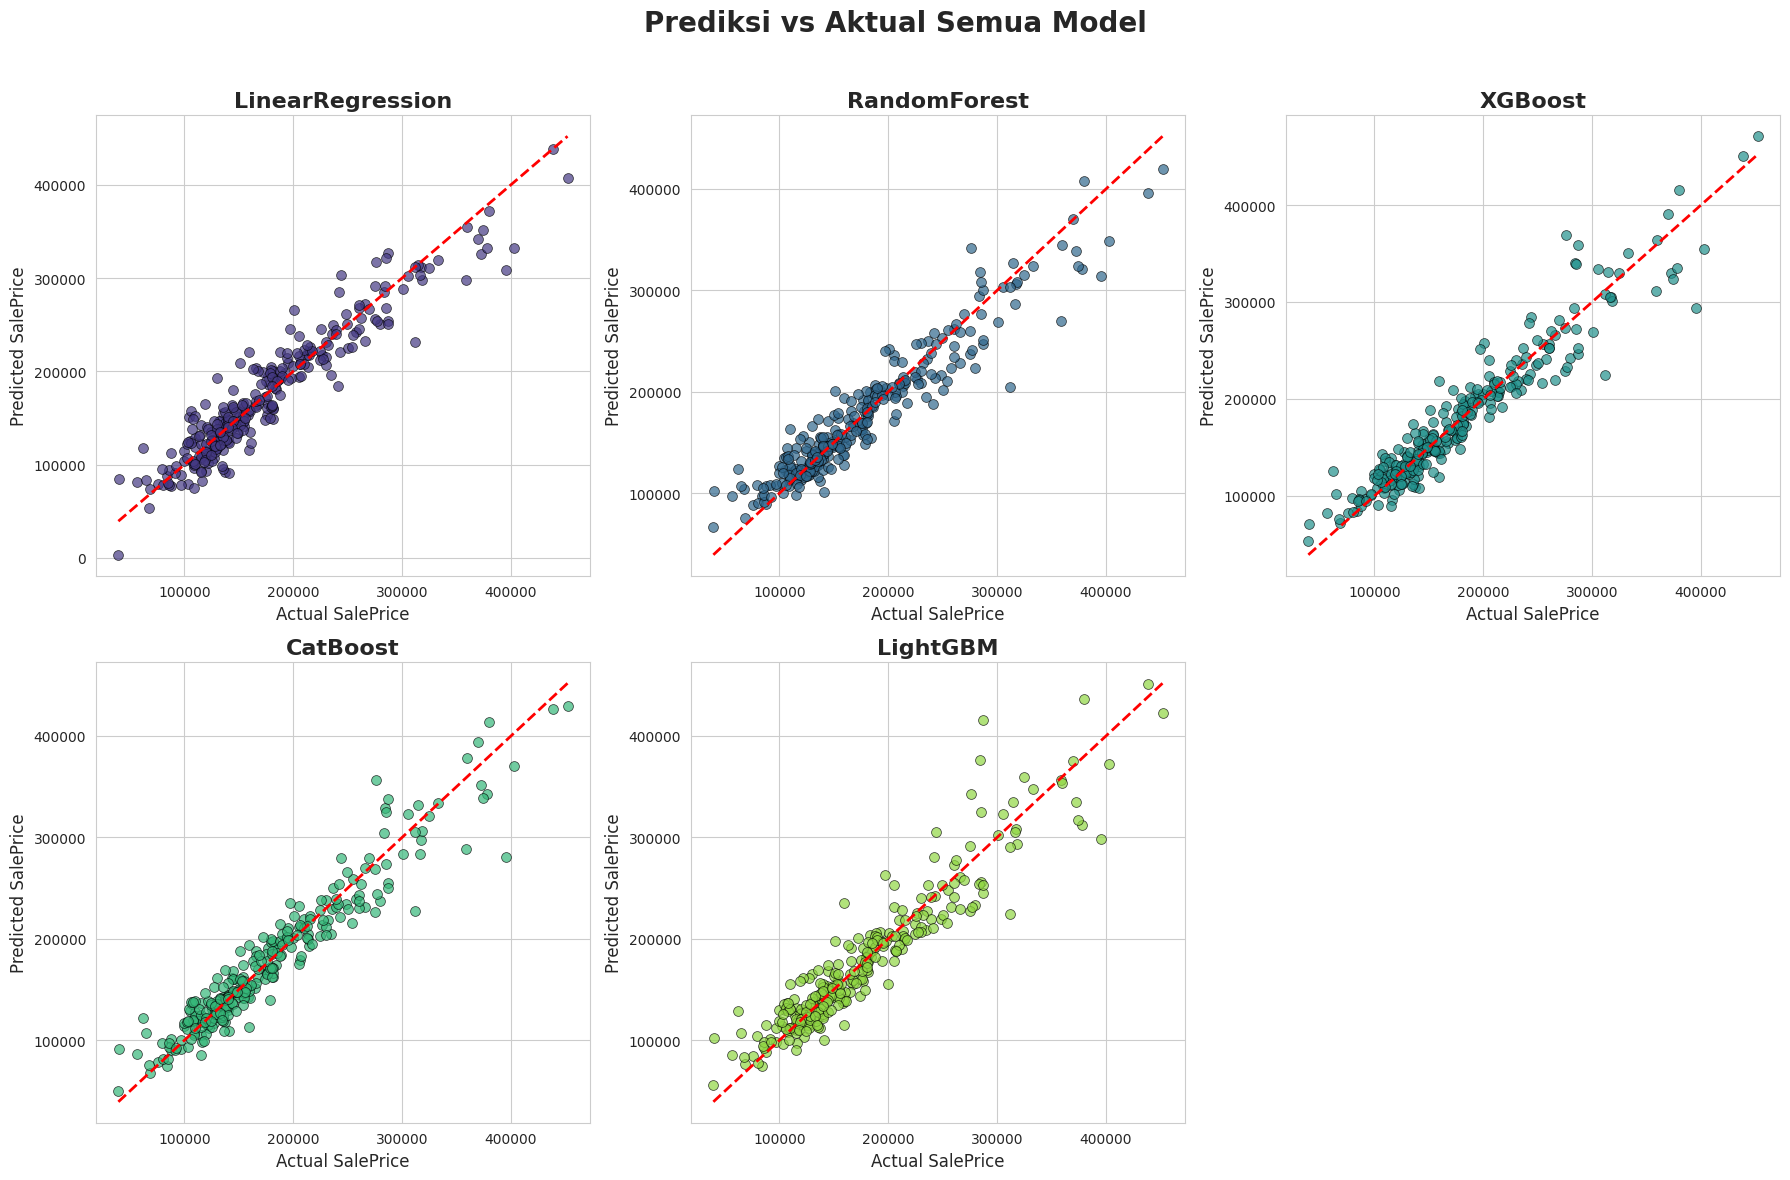

In [ ]:
# Kumpulkan model dan prediksi
models = {
    'LinearRegression': (final_model_ridge, X_test),
    'RandomForest': (best_rf_model, X_rf_test),
    'XGBoost': (best_xgb_model, X_xgb_test),
    'CatBoost': (best_cat_model, X_cat_test_opt),
    'LightGBM': (best_lgb_model, X_xgb_test)
}

y_tests = {
    'LinearRegression': y_test,
    'RandomForest': y_test,
    'XGBoost': y_test,
    'CatBoost': y_test,
    'LightGBM': y_test
}

sns.set_style("whitegrid")
palette = sns.color_palette("viridis", n_colors=len(models))

# Buat figure
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, (name, (model, X_test_model)) in enumerate(models.items()):
    y_pred = model.predict(X_test_model)
    y_true = y_tests[name]

    sns.scatterplot(x=y_true, y=y_pred, ax=axes[i],
                    color=palette[i], s=50, alpha=0.7, edgecolor='k')

    # Garis ideal
    axes[i].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()],
                 'r--', linewidth=2)

    axes[i].set_title(f"{name}", fontsize=16, fontweight='bold')
    axes[i].set_xlabel("Actual SalePrice", fontsize=12)
    axes[i].set_ylabel("Predicted SalePrice", fontsize=12)
    axes[i].tick_params(axis='both', labelsize=10)

# Hapus subplot kosong
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Prediksi vs Aktual Semua Model", fontsize=20, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Feature Importance

In [ ]:
best_model_name = best_model_tuning_sorted.loc[0, 'model']
print("Best model:", best_model_name)
if best_model_name in ['LightGBM', 'XGBoost', 'RandomForest', 'CatBoost']:
    best_model = {
        'LightGBM': lgb_model,
        'XGBoost': xgb_model,
        'RandomForest': rf_model,
        'CatBoost': cat_model
    }[best_model_name]

    importances = pd.Series(best_model.feature_importances_, index=X_train.columns)
    importances = importances.sort_values(ascending=False)

    print(importances)

if best_model_name == 'LinearRegression':
    importances = pd.Series(best_model.coef_, index=X_train.columns).abs().sort_values(ascending=False)
    print(importances)


Best model: CatBoost
TotalLivArea          22.685212
OverallQual           12.403107
GrLivArea              5.828229
ExterQual_num          4.487549
BsmtFinSF1             2.669158
KitchenQual_num        2.650599
GarageCars             2.612900
LotArea                2.465424
TotalBath              2.433460
BsmtQual               2.373099
Fireplaces             2.141433
BsmtExposure           2.037293
GarageArea             1.906792
TotalPorch             1.879563
OverallCond            1.688900
YearBuilt              1.593638
TotalBsmtSF            1.536899
BsmtQual_num           1.476316
AgeAtSale              1.469492
MSZoning               1.353245
YearRemodAdd           1.275550
GarageAge              1.180680
SaleCondition          1.174865
RoomDensity            1.125721
TotRmsAbvGrd           1.044700
1stFlrSF               1.042312
HalfBath               1.036426
Neighborhood           0.972285
BldgType               0.963750
LotShape               0.963369
2ndFlrSF           

In [ ]:
# --- Build DataFrame dari importances ---
df_feat = pd.DataFrame({
    'Feature': importances.index,
    'Importance': importances.values
})

# --- Filter fitur yang importance > 1 ---
df_feat = df_feat[df_feat['Importance'] > 0.001]

# --- Ambil Top 20 terbesar ---
df_feat = df_feat.sort_values(by='Importance', ascending=False).head(20)

# --- Urutkan ascending untuk tampilan bar horizontal ---
df_feat = df_feat.sort_values(by='Importance', ascending=True)

# --- Tandai Top 5 terbesar (warna orange), lainnya steelblue ---
df_feat['Color'] = [
    'orange' if i >= len(df_feat) - 5 else 'steelblue'
    for i in range(len(df_feat))
]

# --- Tinggi figure otomatis berdasarkan jumlah fitur ---
fig_height = max(400, len(df_feat) * 30)

# --- Plot horizontal bar ---
fig = px.bar(
    df_feat,
    x='Importance',
    y='Feature',
    orientation='h',
    color='Color',
    text='Importance',
    title='Top 20 Selected Features Importance - Top 5 Highlighted',
    height=fig_height
)

# --- Layout & formatting ---
fig.update_layout(
    showlegend=False,
    template='plotly_white',
    margin=dict(l=150, r=50, t=80, b=50)
)

fig.update_traces(
    texttemplate='%{text:.2f}',
    textposition='outside'
)

fig.show()
